<a href="https://colab.research.google.com/github/vieduy/AugmentedReality/blob/main/hotel_booking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

import folium
from folium.plugins import HeatMap
import plotly.express as px

plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

In [ ]:
# import datasets
df = pd.read_csv('hotel_bookings.csv')
df.head()

,Hotel,Is canceled,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Meal,Market Segment,Distribution Channel,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Deposit type,Agent,Company,Days in waiting list,Was in waiting list,Customer type,Adr,Total of special requests
0,Resort Hotel,0,342,0,0,2,0,0,BB,Direct,Direct,0,0.0,3,No Deposit,0,0,0,0,Transient,0.0,0
1,Resort Hotel,0,737,0,0,2,0,0,BB,Direct,Direct,0,0.0,4,No Deposit,0,0,0,0,Transient,0.0,0
2,Resort Hotel,0,7,0,1,1,0,0,BB,Direct,Direct,0,0.0,0,No Deposit,0,0,0,0,Transient,75.0,0
3,Resort Hotel,0,13,0,1,1,0,0,BB,Corporate,Corporate,0,0.0,0,No Deposit,1,0,0,0,Transient,75.0,0
4,Resort Hotel,0,14,0,2,2,0,0,BB,Online TA,TA/TO,0,0.0,0,No Deposit,1,0,0,0,Transient,98.0,1


In [ ]:
# Kiểm tra giá trị null (giá trị rỗng)

null = pd.DataFrame({'Null Values' : df.isna().sum(), 'Percentage Null Values' : (df.isna().sum()) / (df.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
Hotel,0,0.0
Is canceled,0,0.0
Lead time,0,0.0
Stays In Weekend Nights,0,0.0
Stays In Week Nights,0,0.0
Adults,0,0.0
Children,0,0.0
Babies,0,0.0
Meal,0,0.0
Market Segment,0,0.0


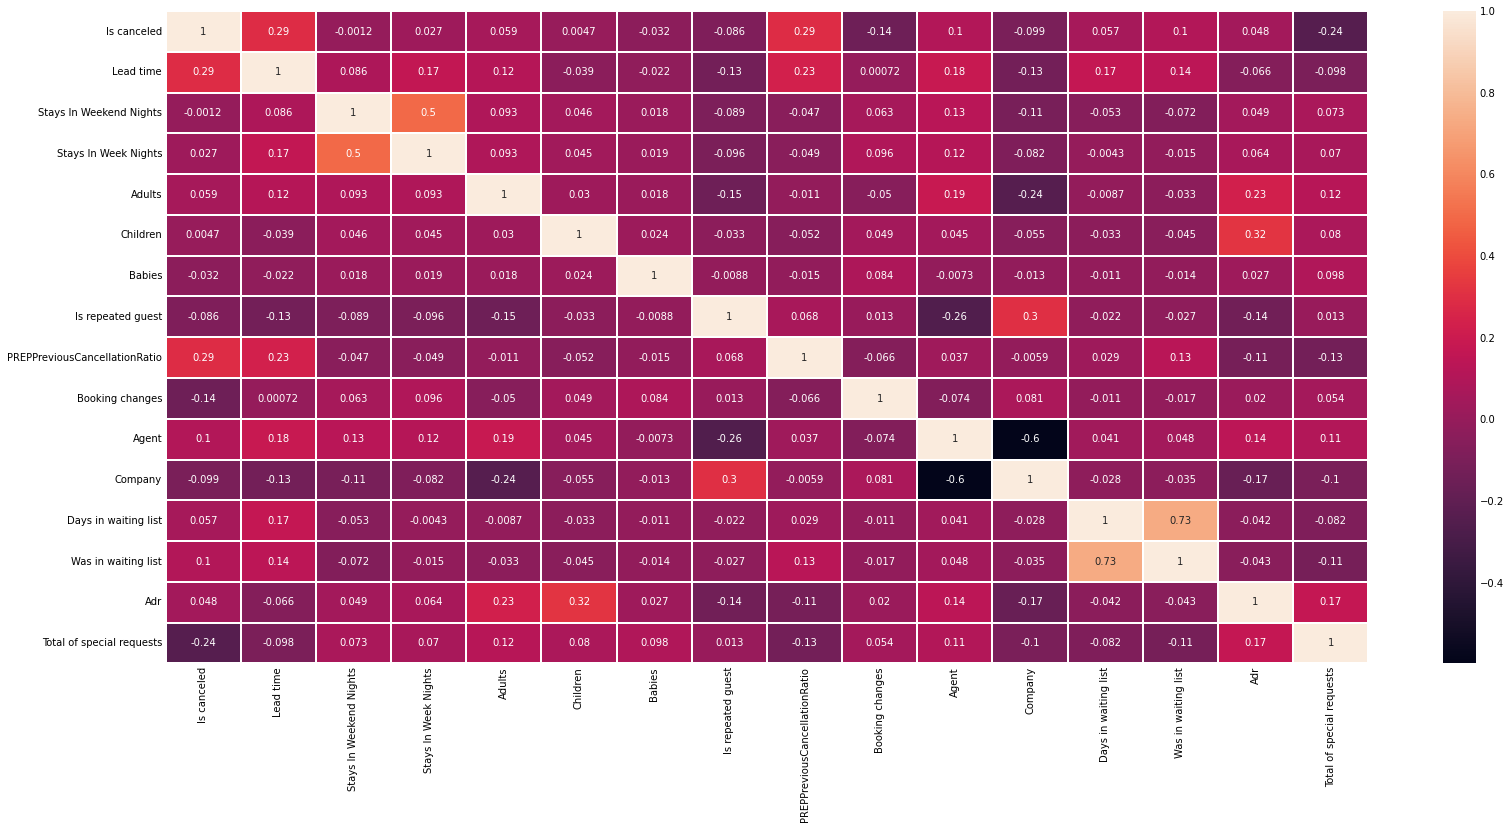

In [ ]:
# confusion matrix (dùng để visuallize)

plt.figure(figsize = (24, 12))

corr = df.corr()
sns.heatmap(corr, annot = True, linewidths = 1)
plt.show()

In [ ]:
# kiểm tra mối tương quan của các trường dữ liệu với kết quả cancel hay không. tương quan thấp sẽ loại (vì không ảnh hưởng tới kết quả)

correlation = df.corr()['Is canceled'].abs().sort_values(ascending = False)
correlation

Is canceled                      1.000000
Lead time                        0.294275
PREPPreviousCancellationRatio    0.290665
Total of special requests        0.237386
Booking changes                  0.143367
Was in waiting list              0.103144
Agent                            0.101211
Company                          0.099189
Is repeated guest                0.085993
Adults                           0.059347
Days in waiting list             0.057400
Adr                              0.048005
Babies                           0.032359
Stays In Week Nights             0.027005
Children                         0.004691
Stays In Weekend Nights          0.001213
Name: Is canceled, dtype: float64

In [ ]:
# # loại bỏ những cột không liên quan 

# useless_col = ['days_in_waiting_list', 'arrival_date_year', 'arrival_date_year', 'assigned_room_type',
#                'reserved_room_type', 'country', 'required_car_parking_spaces']

# df.drop(useless_col, axis = 1, inplace = True)
# df.head()

In [ ]:
# Chuyển những cột chữ sang dạng số để tính toán

cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols

['Hotel',
 'Meal',
 'Market Segment',
 'Distribution Channel',
 'Deposit type',
 'Customer type']

In [ ]:
cat_df = df[cat_cols]
cat_df.head()

,Hotel,Meal,Market Segment,Distribution Channel,Deposit type,Customer type
0,Resort Hotel,BB,Direct,Direct,No Deposit,Transient
1,Resort Hotel,BB,Direct,Direct,No Deposit,Transient
2,Resort Hotel,BB,Direct,Direct,No Deposit,Transient
3,Resort Hotel,BB,Corporate,Corporate,No Deposit,Transient
4,Resort Hotel,BB,Online TA,TA/TO,No Deposit,Transient


In [ ]:
for col in cat_df.columns:
    print(f"{col}: \n{cat_df[col].unique()}\n")

Hotel: 
['Resort Hotel' 'City Hotel']

Meal: 
['BB' 'FB' 'HB' 'SC']

Market Segment: 
['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Aviation']

Distribution Channel: 
['Direct' 'Corporate' 'TA/TO' 'GDS']

Deposit type: 
['No Deposit' 'Refundable' 'Non Refund']

Customer type: 
['Transient' 'Contract' 'Transient-Party' 'Group']



In [ ]:
# gán số vào các giá trị chữ

cat_df['Hotel'] = cat_df['Hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})

cat_df['Meal'] = cat_df['Meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})

cat_df['Market Segment'] = cat_df['Market Segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})

cat_df['Distribution Channel'] = cat_df['Distribution Channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})

cat_df['Deposit type'] = cat_df['Deposit type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})

cat_df['Customer type'] = cat_df['Customer type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})

# cat_df['year'] = cat_df['year'].map({2015: 0, 2014: 1, 2016: 2, 2017: 3})

In [ ]:
num_df = df.drop(columns = cat_cols, axis = 1)
num_df.drop('Is canceled', axis = 1, inplace = True)
num_df

,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Agent,Company,Days in waiting list,Was in waiting list,Adr,Total of special requests
0,342,0,0,2,0,0,0,0.0,3,0,0,0,0,0.00,0
1,737,0,0,2,0,0,0,0.0,4,0,0,0,0,0.00,0
2,7,0,1,1,0,0,0,0.0,0,0,0,0,0,75.00,0
3,13,0,1,1,0,0,0,0.0,0,1,0,0,0,75.00,0
4,14,0,2,2,0,0,0,0.0,0,1,0,0,0,98.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118211,23,2,5,2,0,0,0,0.0,0,1,0,0,0,96.14,0
118212,102,2,5,3,0,0,0,0.0,0,1,0,0,0,225.43,2
118213,34,2,5,2,0,0,0,0.0,0,1,0,0,0,157.71,4
118214,109,2,5,2,0,0,0,0.0,0,1,0,0,0,104.40,0


In [ ]:
# chuẩn hóa
num_df['Lead time'] = np.log(num_df['Lead time'] + 1)
num_df['Agent'] = np.log(num_df['Agent'] + 1)
num_df['Company'] = np.log(num_df['Company'] + 1)
num_df['Adr'] = np.log(num_df['Adr'] + 1)

In [ ]:
num_df.head()

,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Agent,Company,Days in waiting list,Was in waiting list,Adr,Total of special requests
0,5.837730,0,0,2,0,0,0,0.0,3,0.000000,0.0,0,0,0.000000,0
1,6.603944,0,0,2,0,0,0,0.0,4,0.000000,0.0,0,0,0.000000,0
2,2.079442,0,1,1,0,0,0,0.0,0,0.000000,0.0,0,0,4.330733,0
3,2.639057,0,1,1,0,0,0,0.0,0,0.693147,0.0,0,0,4.330733,0
4,2.708050,0,2,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.595120,1


In [ ]:
X = pd.concat([cat_df, num_df], axis = 1)
y = df['Is canceled']

In [ ]:
X.head()

,Hotel,Meal,Market Segment,Distribution Channel,Deposit type,Customer type,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Agent,Company,Days in waiting list,Was in waiting list,Adr,Total of special requests
0,0,0,0,0,0,0,5.837730,0,0,2,0,0,0,0.0,3,0.000000,0.0,0,0,0.000000,0
1,0,0,0,0,0,0,6.603944,0,0,2,0,0,0,0.0,4,0.000000,0.0,0,0,0.000000,0
2,0,0,0,0,0,0,2.079442,0,1,1,0,0,0,0.0,0,0.000000,0.0,0,0,4.330733,0
3,0,0,1,1,0,0,2.639057,0,1,1,0,0,0,0.0,0,0.693147,0.0,0,0,4.330733,0
4,0,0,2,2,0,0,2.708050,0,2,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.595120,1


In [ ]:
# splitting data into training set and test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_train.head()

,Hotel,Meal,Market Segment,Distribution Channel,Deposit type,Customer type,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Agent,Company,Days in waiting list,Was in waiting list,Adr,Total of special requests
101344,1,0,3,2,0,0,0.693147,0,1,1,0,0,0,0.0,0,0.693147,0.0,0,0,4.330733,0
18692,0,0,1,1,0,0,0.000000,1,0,1,0,0,1,0.0,0,0.693147,0.0,0,0,3.433987,0
46413,1,0,3,2,0,2,0.693147,2,1,1,0,0,0,0.0,0,0.693147,0.0,0,0,4.110874,0
117437,1,0,2,2,0,0,5.521461,2,2,2,1,0,0,0.0,0,0.693147,0.0,0,0,4.894326,1
46538,1,0,2,2,0,0,4.077537,3,7,1,0,0,0,0.0,0,0.693147,0.0,0,0,4.211387,1


In [ ]:
xgb = XGBClassifier(booster = 'gbtree', learning_rate = 0.1, max_depth = 5, n_estimators = 180)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
conf = confusion_matrix(y_test, y_pred_xgb)
clf_report = classification_report(y_test, y_pred_xgb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_xgb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8253489355702806
Confusion Matrix : 
[[20867  1418]
 [ 4776  8404]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     22285
           1       0.86      0.64      0.73     13180

    accuracy                           0.83     35465
   macro avg       0.83      0.79      0.80     35465
weighted avg       0.83      0.83      0.82     35465



In [ ]:
X_test.head()

,Hotel,Meal,Market Segment,Distribution Channel,Deposit type,Customer type,Lead time,Stays In Weekend Nights,Stays In Week Nights,Adults,Children,Babies,Is repeated guest,PREPPreviousCancellationRatio,Booking changes,Agent,Company,Days in waiting list,Was in waiting list,Adr,Total of special requests
22657,0,0,2,2,0,0,2.995732,1,3,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.465908,1
90953,1,2,2,2,0,0,3.828641,1,3,3,0,0,0,0.0,0,0.693147,0.0,0,0,5.066890,2
29157,0,2,2,2,0,0,3.258097,0,2,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.615121,1
57927,1,0,3,2,3,0,5.575949,0,2,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.709530,0
115587,1,0,3,2,0,0,5.081404,1,0,2,0,0,0,0.0,0,0.693147,0.0,0,0,4.395683,1


In [ ]:
cols=['Hotel', 'Meal', 'Market Segment', 'Distribution Channel', 'Deposit type', 'Customer type', 'Lead time', 'Stays In Weekend Nights',
      'Stays In Week Nights', 'Adults', 'Children', 'Babies', 'Is repeated guest', 'PREPPreviousCancellationRatio', 
      'Booking changes', 'Agent', 'Company', 'Days in waiting list', 'Was in waiting list', 'Adr', 'Total of special requests']

test_dict = pd.DataFrame(columns=cols)
for col in cols:
  inp = input('nhap {}: '.format(col))
  if col in ['Hotel', 'Meal', 'Market Segment', 'Distribution Channel', 'Deposit type', 'Customer type']:
    test_dict[col] = [inp]

  else: 
    test_dict[col] = [int(inp)]

test_dict.head()

nhap Hotel: 0
nhap Meal: FB
nhap Market Segment: Direct
nhap Distribution Channel: Direct
nhap Deposit type: No Deposit
nhap Customer type: Contract
nhap Lead time: 245
nhap Stays In Weekend Nights: 2
nhap Stays In Week Nights: 2
nhap Adults: 0
nhap Children: 1
nhap Babies: 0
nhap Is repeated guest: 0
nhap PREPPreviousCancellationRatio: 0
nhap Booking changes: 1
nhap Agent: 0
nhap Company: 1
nhap Days in waiting list: 0
nhap Was in waiting list: 0
nhap Adr: 300
nhap Total of special requests: 1
[0]


In [ ]:
cat_cols = [col for col in test_dict.columns if test_dict[col].dtype == 'O']
cat_df = test_dict[cat_cols]
cat_df['Hotel'] = cat_df['Hotel'].map({'Resort Hotel' : 0, 'City Hotel' : 1})
cat_df['Meal'] = cat_df['Meal'].map({'BB' : 0, 'FB': 1, 'HB': 2, 'SC': 3, 'Undefined': 4})
cat_df['Market Segment'] = cat_df['Market Segment'].map({'Direct': 0, 'Corporate': 1, 'Online TA': 2, 'Offline TA/TO': 3,
                                                           'Complementary': 4, 'Groups': 5, 'Undefined': 6, 'Aviation': 7})
cat_df['Distribution Channel'] = cat_df['Distribution Channel'].map({'Direct': 0, 'Corporate': 1, 'TA/TO': 2, 'Undefined': 3,
                                                                       'GDS': 4})
cat_df['Deposit type'] = cat_df['Deposit type'].map({'No Deposit': 0, 'Refundable': 1, 'Non Refund': 3})
cat_df['Customer type'] = cat_df['Customer type'].map({'Transient': 0, 'Contract': 1, 'Transient-Party': 2, 'Group': 3})


num_df = test_dict.drop(columns = cat_cols, axis = 1)
num_df['Lead time'] = np.log(num_df['Lead time'] + 1)
num_df['Agent'] = np.log(num_df['Agent'] + 1)
num_df['Company'] = np.log(num_df['Company'] + 1)
num_df['Adr'] = np.log(num_df['Adr'] + 1)

In [ ]:
x_test = pd.concat([cat_df, num_df], axis = 1)
y_pred_xgb = xgb.predict(x_test)

In [ ]:
print('Không hủy') if y_pred_xgb[0] == 0 else print('Hủy')

Không hủy
